In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder


# Analyzing Bias Towards Women in Banking Data

The model analyzes a CSV of Credit Score data to detect potential bias towards women. It follows these steps:

1. **Preprocessing**: Reads the data, sets 'CustomerID' as the index, and encodes categorical columns, performs one-hot encoding on categorical features and normalizes continuous features.


2. **Sampling**: Samples 10% of the records, swapping genders (males to females and vice versa).
3. **Prediction**: Uses KNN to predict the decision (label) for the modified data.(After the regulator receives full access to the credit score system it uses it instead of predicting the decision)
4. **Grouping**: Groups all males and females from both original and modified data.
5. **Calculates mean**: Calculates the mean of the score for men and women groups separately.

**Repeat 2-5 for 1000 iterations with different parameters** 

**Statistic Analysis**
5. **T-test**: Compares means of each runs to check for significant differences, indicating potential bias towards females.
6. **plot results**


# Parameters

# Pre-process

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

def preprocess_for_knn(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

    # Separate categorical and continuous features
    categorical_features = ['MaritalStatus', 'EmploymentStatus', 'ExistingLoans']
    continuous_features = ['Age', 'NumDependents', 'AnnualIncome', 'LoanAmount', 'CreditScore', 'TenureWithBank', 'AccountBalance', 'RequestedCreditLine']
    
    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_categorical_data = encoder.fit_transform(data[categorical_features])
    encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
    
    # Normalize continuous features
    scaler = MinMaxScaler()
    normalized_continuous_data = scaler.fit_transform(data[continuous_features])
    normalized_continuous_df = pd.DataFrame(normalized_continuous_data, columns=continuous_features)
    
    # Combine all features into a single DataFrame
    X = pd.concat([data[['Gender']], encoded_categorical_df, normalized_continuous_df], axis=1)
    
    y = data['Decision']

    return X, y



# Knn algorithm

Train Knn, sample test data, manipulate the data and predict the new labels
devide the data into the distribution of labels between males and females

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def knn_algorithm(X, y, k, test_size=0.1, random_state=42):
    """
    Perform KNN algorithm with gender reversal in test set, using median prediction.

    Parameters:
    X (DataFrame): Features dataset
    y (Series): Target variable (continuous, representing money)
    label_encoders (dict): Dictionary of label encoders
    label_column (str): Name of the label column
    k (int): Number of neighbors for KNN
    test_size (float): Proportion of dataset to include in test split
    random_state (int): Random state for reproducibility

    Returns:
    tuple: (y_male, y_female, knn_model, mae, mse)
    """

    # Input validation
    if not 0 < test_size < 1:
        raise ValueError("test_size should be between 0 and 1")
    if k <= 0:
        raise ValueError("k should be a positive integer")


    # Step 1: Split the data for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Step 2: Reverse the 'gender' column in the test set
    X_test_modified = X_test.copy()
    y_test_modified = y_test.copy()
    X_test_modified['Gender'] = X_test_modified['Gender'].apply(lambda x: 1 - x)

    # Step 3: Perform KNN Regression
    knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)

    # Step 4: Create a custom predict function that returns the median
    def predict_median(X):
        distances, indices = knn.kneighbors(X)
        nearest_targets = y_train.iloc[indices.flatten()].values.reshape(indices.shape)
        return np.median(nearest_targets, axis=1)

    # Step 5: Predict the modified test set
    y_modified_pred = predict_median(X_test_modified)

    # Step 6: Calculate error metrics
    y_test_pred = predict_median(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)

    # Step 7: Define y_male, y_female as the decision distribution for males and females
    y_test_male = y_test[X_test['Gender'] == 1].values
    y_modified_male = y_modified_pred[X_test_modified['Gender'] == 1]
    y_male = np.concatenate((y_test_male, y_modified_male))
    
    y_test_female = y_test[X_test['Gender'] == 0].values
    y_modified_female = y_modified_pred[X_test_modified['Gender'] == 0]
    y_female = np.concatenate((y_test_female, y_modified_female))

    return y_male, y_female



# Run Audit Algorithm

In [5]:
# Load the data and preprocess it
file_path = 'credit_score_database.csv'
X, y = preprocess_for_knn(file_path)
X

,Gender,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,EmploymentStatus_Retired,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,ExistingLoans_Yes,Age,NumDependents,AnnualIncome,LoanAmount,CreditScore,TenureWithBank,AccountBalance,RequestedCreditLine
0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.711864,0.6,0.948877,0.955079,0.835772,0.540541,0.276688,0.221784
1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.932203,0.4,0.216473,0.714569,0.874797,0.702703,0.333028,0.249947
2,1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.542373,0.8,0.054397,0.919624,0.531707,0.189189,0.389125,0.443970
3,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.305085,0.6,0.229425,0.928705,0.313821,0.756757,0.229396,0.424436
4,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.779661,0.6,0.683064,0.263780,0.658537,0.432432,0.668654,0.281172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.271186,0.4,0.544651,0.405194,0.650407,0.621622,0.386956,0.759848
1296,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.220339,0.0,0.014353,0.727699,0.530081,0.729730,0.543769,0.208832
1297,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.491525,0.2,0.777379,0.876111,0.414634,0.270270,0.381891,0.994241
1298,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.440678,0.0,0.140455,0.680059,0.977236,0.243243,0.087594,0.552394


In [6]:
from tqdm import tqdm
male_means = []
female_means = []
print("Running the algorithm")
for _ in tqdm(range(1000)):
    for k in [3,4,5,6,7]:
        y_male,y_female = knn_algorithm(X, y, k)
        male_means.append(np.mean(y_male))
        female_means.append(np.mean(y_female))
        
        

Running the algorithm


100%|██████████| 1000/1000 [00:36<00:00, 27.78it/s]


# Analyze Results and perform T-test

In [7]:
t_stat, p_value = ttest_ind(male_means, female_means)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the means")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means")

T-statistic: 131.216, P-value: 0.000
Reject the null hypothesis: There is a significant difference between the means


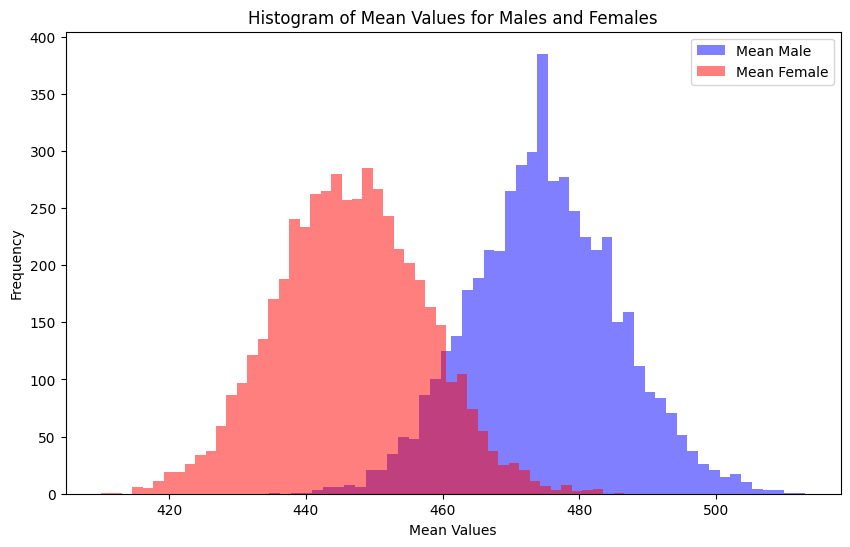

In [12]:
#Draw histograms for males and females
import matplotlib.pyplot as plt
bins = 50
plt.figure(figsize=(10, 6))
plt.hist(male_means, bins=bins, alpha=0.5, label='Mean Male', color='blue')
plt.hist(female_means, bins=bins, alpha=0.5, label='Mean Female', color='red')
plt.xlabel('Mean Values')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Values for Males and Females')
plt.legend(loc='upper right')
plt.show()

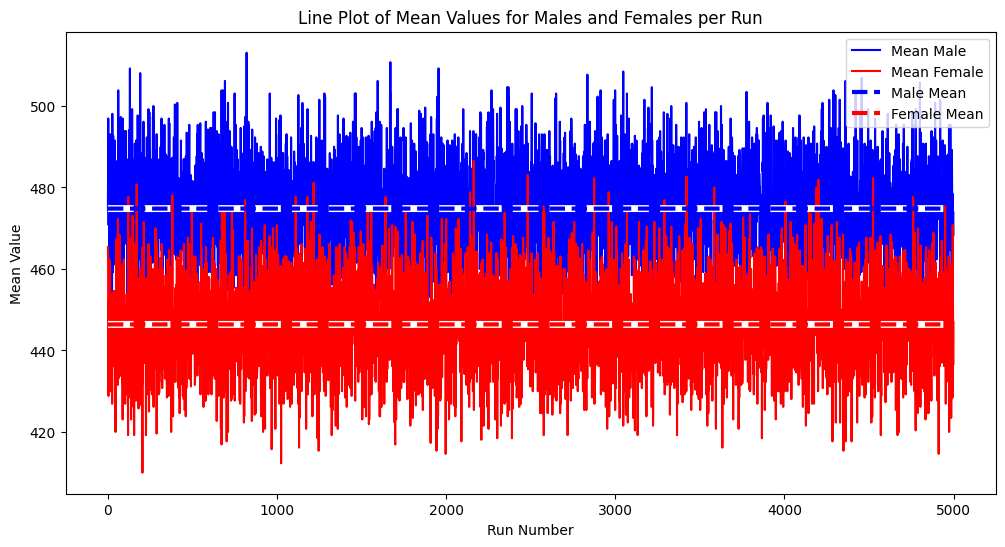

In [11]:
plt.figure(figsize=(12, 6))

# Plot the male and female mean values
plt.plot(male_means, label='Mean Male', color='blue')
plt.plot(female_means, label='Mean Female', color='red')

# Calculate and plot the mean lines
male_mean_line = [np.mean(male_means)] * len(male_means)
female_mean_line = [np.mean(female_means)] * len(female_means)


plt.plot(male_mean_line, linestyle='--', color='white', linewidth=5, solid_capstyle='round')
plt.plot(female_mean_line, linestyle='--', color='white', linewidth=5, solid_capstyle='round')
plt.plot(male_mean_line, linestyle='--', color='blue',linewidth=3, label='Male Mean')
plt.plot(female_mean_line, linestyle='--', color='red',linewidth=3, label='Female Mean')

plt.xlabel('Run Number')
plt.ylabel('Mean Value')
plt.title('Line Plot of Mean Values for Males and Females per Run')
plt.legend(loc='upper right')
plt.show()
